# Projet Classification de données hyperspectrales

Les images hyperspectrales sont un type de données que vous avez déjà traitées dans un précédent TP, et qui correspondent à des images dont le contenu spectral est enrichi. L'objectif de ce mini-projet est une compétition (entre vous) pour la classification des pixels d'une image hyperspectrale.



Vous allez avoir à disposition une image hyperspectrale (survol de l'Université de pavie), et votre objectif est de déterminer automatiquement la nature des pixels qui composent l'image.

On commence par charger l'image et quelques imports utiles


In [1]:
import numpy as np
from scipy.io import loadmat
import pylab as pl

In [2]:
pavia = np.load('pavia.npy')

dont voici les dimensions


In [3]:
pavia.shape

(610, 340, 103)

Voici un aperçu de cette image (on choisit 3 bandes spectrales parmi les 103 pour simuler le bleu, vert et rouge)

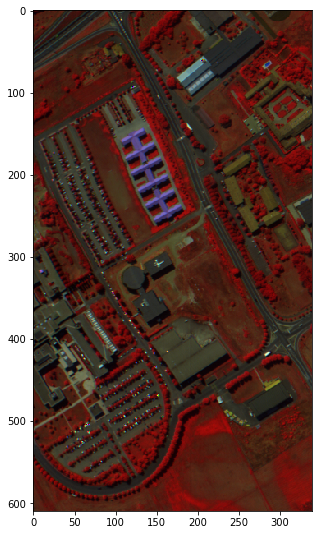

In [4]:
nbands=[100,50,10]

pl.figure(figsize=(5,10))
pl.imshow(pavia[:,:,nbands])
pl.show()

Je donne en plus de cette image une série de labels correspondant à la classe associée à certains pixels


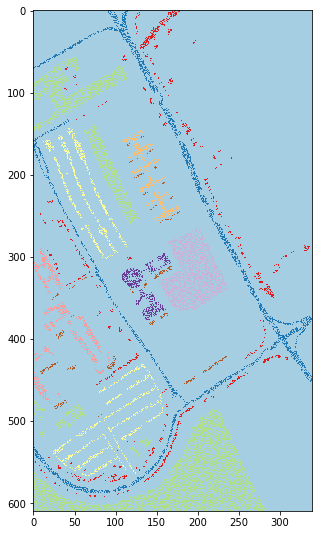

In [5]:
pavia_vt = np.load('train_set.npy')
pl.figure(figsize=(5,10))
pl.imshow(pavia_vt,cmap='Paired')
pl.show()

Vous noterez que **la classe 0 correspond à tous les pixels à étiquetter**




L'objectif est que vous obteniez la classe de tous les autres pixels en utilisant un réseau de neurones que vous designerez selon votre choix. L'objectif est d'obtenir les meilleures performances sur ce jeu de données, aussi vous penserez à découper votre jeu de données d'entrainement en jeux de train/validation. Je vous laisse toute latitude sur ces choix. 



En plus du notebook contenant votre code, vous me remettrez un fichier dont la structure est équivalente à celle de 'train_set.npy', contenant une des 9 neufs classes numérotées de 1 à 9 **pour chaque pixel**  (un espace de rendu sera disponible dans l'ENT).

### Import

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D, Flatten

### Functions

In [7]:
def pad_width(ps):
    return ((ps - 1) // 2, (ps - 1) // 2 + 1) if (ps % 2 == 0) else ((ps - 1) // 2, (ps - 1) // 2)

def padded(m, pw):
    return np.pad(m, (pw, pw, (0, 0)))

def patched(m, pad, p, pw):
    patch = np.zeros((m.shape[0], m.shape[1], p, p, m.shape[2]))
    l, r = pw
    x = y = 0
    for i in range(l, l + m.shape[0]):
        for j in range(l, l + m.shape[1]):
            patch[x, y] = pad[i-l: i+l+1, j-r: j+r+1]
            y += 1
        y = 0
        x += 1
    return patch

### Reshaping

In [8]:
patch_size = 5

pw = pad_width(patch_size)
patched_pavia = patched(pavia, padded(pavia, pw), patch_size, pw)

### Preprocessing

In [9]:
inds = np.nonzero(pavia_vt)
data = patched_pavia[inds]
target = pavia_vt[inds]

x, X_test, y, y_test = train_test_split(data, target, test_size=0.15, random_state=37)
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size = 0.25, random_state=37)

scaler = StandardScaler().fit(data.reshape(-1, data.shape[-1]))
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

pred_shape = [patched_pavia.shape[0] * patched_pavia.shape[1]]
pred_shape.extend(list(patched_pavia.shape[2:]))
X_pred = scaler.transform(patched_pavia.reshape((np.prod(patched_pavia.shape[:-1]), patched_pavia.shape[-1]))).reshape(tuple(pred_shape))

Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
Y_val = to_categorical(y_val)

### Workflow

In [10]:
model = Sequential()
model.add(Conv2D(X_train.shape[1], kernel_size=(patch_size, patch_size), input_shape=X_train.shape[1:], activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(Conv2D(X_train.shape[1] * 2, kernel_size=(patch_size, patch_size), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Flatten())
model.add(Dense(X_train.shape[1] * 4, activation='relu'))
model.add(Dense(Y_train.shape[1], activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=200, batch_size=256, validation_data=(X_val, Y_val))

Epoch 1/200
54/54 [==============================] - 1s 17ms/step - loss: 1.7552 - accuracy: 0.4431 - val_loss: 57.0040 - val_accuracy: 0.0304
Epoch 2/200
54/54 [==============================] - 1s 10ms/step - loss: 1.0077 - accuracy: 0.6759 - val_loss: 144.5159 - val_accuracy: 0.1828
Epoch 3/200
54/54 [==============================] - 1s 11ms/step - loss: 0.6877 - accuracy: 0.7618 - val_loss: 171.5569 - val_accuracy: 0.0961
Epoch 4/200
54/54 [==============================] - 1s 10ms/step - loss: 0.6087 - accuracy: 0.7713 - val_loss: 332.6512 - val_accuracy: 0.4473
Epoch 5/200
54/54 [==============================] - 1s 11ms/step - loss: 0.5643 - accuracy: 0.7785 - val_loss: 271.3590 - val_accuracy: 0.4517
Epoch 6/200
54/54 [==============================] - 1s 11ms/step - loss: 0.5235 - accuracy: 0.7940 - val_loss: 362.2701 - val_accuracy: 0.4484
Epoch 7/200
54/54 [==============================] - 1s 11ms/step - loss: 0.4742 - accuracy: 0.8118 - val_loss: 269.6060 - val_accuracy: 

54/54 [==============================] - 1s 11ms/step - loss: 0.0744 - accuracy: 0.9750 - val_loss: 591.4653 - val_accuracy: 0.4891
Epoch 58/200
54/54 [==============================] - 1s 11ms/step - loss: 0.0740 - accuracy: 0.9754 - val_loss: 691.4191 - val_accuracy: 0.3846
Epoch 59/200
54/54 [==============================] - 1s 10ms/step - loss: 0.0733 - accuracy: 0.9749 - val_loss: 488.5888 - val_accuracy: 0.3877
Epoch 60/200
54/54 [==============================] - 1s 11ms/step - loss: 0.0727 - accuracy: 0.9756 - val_loss: 557.3057 - val_accuracy: 0.2829
Epoch 61/200
54/54 [==============================] - 1s 10ms/step - loss: 0.0809 - accuracy: 0.9723 - val_loss: 484.2480 - val_accuracy: 0.3591
Epoch 62/200
54/54 [==============================] - 1s 11ms/step - loss: 0.0825 - accuracy: 0.9732 - val_loss: 698.1474 - val_accuracy: 0.1529
Epoch 63/200
54/54 [==============================] - 1s 10ms/step - loss: 0.0685 - accuracy: 0.9783 - val_loss: 549.2528 - val_accuracy: 0.400

54/54 [==============================] - 1s 11ms/step - loss: 0.0438 - accuracy: 0.9859 - val_loss: 784.8516 - val_accuracy: 0.1173
Epoch 114/200
54/54 [==============================] - 1s 10ms/step - loss: 0.0406 - accuracy: 0.9864 - val_loss: 954.2176 - val_accuracy: 0.1074
Epoch 115/200
54/54 [==============================] - 1s 10ms/step - loss: 0.0416 - accuracy: 0.9863 - val_loss: 861.4963 - val_accuracy: 0.1129
Epoch 116/200
54/54 [==============================] - 1s 11ms/step - loss: 0.0422 - accuracy: 0.9861 - val_loss: 695.5741 - val_accuracy: 0.2429
Epoch 117/200
54/54 [==============================] - 1s 11ms/step - loss: 0.0482 - accuracy: 0.9827 - val_loss: 802.7839 - val_accuracy: 0.1182
Epoch 118/200
54/54 [==============================] - 1s 11ms/step - loss: 0.0404 - accuracy: 0.9869 - val_loss: 921.2920 - val_accuracy: 0.1111
Epoch 119/200
54/54 [==============================] - 1s 11ms/step - loss: 0.0536 - accuracy: 0.9833 - val_loss: 1641.3380 - val_accuracy

Epoch 169/200
54/54 [==============================] - 1s 11ms/step - loss: 0.0365 - accuracy: 0.9869 - val_loss: 1242.5990 - val_accuracy: 0.1028
Epoch 170/200
54/54 [==============================] - 1s 11ms/step - loss: 0.0457 - accuracy: 0.9836 - val_loss: 1215.6942 - val_accuracy: 0.1105
Epoch 171/200
54/54 [==============================] - 1s 11ms/step - loss: 0.0387 - accuracy: 0.9875 - val_loss: 1348.5959 - val_accuracy: 0.1041
Epoch 172/200
54/54 [==============================] - 1s 11ms/step - loss: 0.0516 - accuracy: 0.9836 - val_loss: 1078.1049 - val_accuracy: 0.1069
Epoch 173/200
54/54 [==============================] - 1s 11ms/step - loss: 0.0503 - accuracy: 0.9828 - val_loss: 944.6278 - val_accuracy: 0.1582
Epoch 174/200
54/54 [==============================] - 1s 11ms/step - loss: 0.0350 - accuracy: 0.9884 - val_loss: 1017.1959 - val_accuracy: 0.1234
Epoch 175/200
54/54 [==============================] - 1s 11ms/step - loss: 0.0311 - accuracy: 0.9896 - val_loss: 1289.

### Evaluation

In [11]:
score = model.evaluate(X_test, Y_test, verbose=0)
print(model.metrics_names, '-->', score)

['loss', 'accuracy'] --> [0.08450666815042496, 0.9756857752799988]


### Prediction

In [12]:
Y_pred = model.predict(X_pred)
pred = np.array([i + 1 for i in np.argmax(Y_pred, axis=-1)]).reshape(pavia.shape[:-1])
np.save('pavia_conv_result', pred)

### Display

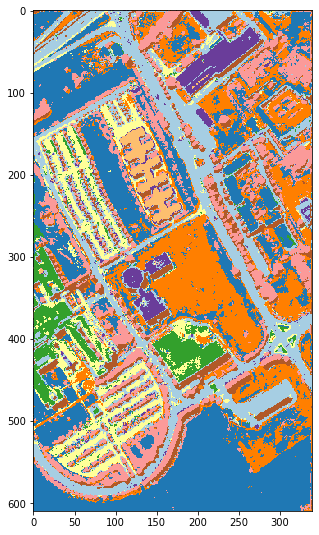

In [13]:
result = np.load('pavia_conv_result.npy')
pl.figure(figsize=(5,10))
pl.imshow(result, cmap='Paired', interpolation='nearest')